In [24]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

In [25]:
def load_images_from_folders(base_dir, target_size):
    images = []
    labels = []
    class_names = sorted(os.listdir(base_dir))
    class_names = [name for name in class_names if name != 'Read me.txt']
    class_mapping = {name: idx for idx, name in enumerate(class_names)}
    
    for folder_name in class_names:
        folder_path = os.path.join(base_dir, folder_name)
        if os.path.isdir(folder_path):
            for file in os.listdir(folder_path):
                if file.endswith('.bmp'):
                    img_path = os.path.join(folder_path, file)
                    img = cv2.imread(img_path)
                    img = cv2.resize(img, target_size)
                    images.append(img)
                    labels.append(class_mapping[folder_name])
                    
    return np.array(images), np.array(labels), class_mapping

base_dir = '/kaggle/input/thermal-images-of-induction-motor'
target_size = (128, 128)
images, labels, class_mapping = load_images_from_folders(base_dir, target_size)
images = images.astype('float32') / 255.0

In [26]:
images_train, images_test, classes_train, classes_test = train_test_split(images, labels, test_size = 0.2, random_state = 42)

In [33]:
import os

def list_classes(directory):
    """
    List all class names in the given directory. Assumes each class is a subfolder.

    Args:
        directory (str): Path to the directory containing the dataset.

    Returns:
        list: A list of class names (subfolder names).
    """
    try:
        # Get a list of all subdirectories (classes)
        class_names = [name for name in os.listdir(directory) if os.path.isdir(os.path.join(directory, name))]
        return class_names
    except Exception as e:
        print(f"Error: {e}")
        return []

# Directory path
dataset_directory = '/kaggle/input/thermal-images-of-induction-motor'

# Get class names
classes = list_classes(dataset_directory)

if classes:
    print("Classes found in the dataset:")
    for idx, class_name in enumerate(classes, 1):
        print(f"{idx}. {class_name}")
else:
    print("No classes found or invalid directory.")


Classes found in the dataset:
1. Fan
2. A&C10
3. A&B50
4. A&C30
5. Noload
6. Rotor-0
7. A&C&B30
8. A30
9. A&C&B10
10. A50
11. A10


In [27]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization

base_model = MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
base_model.trainable = False

# Create the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),  # Reduced parameters compared to Flatten
    BatchNormalization(),
    Dense(64, activation='relu'),  # Reduced units to 64
    Dropout(0.3),  # Reduced dropout rate
    Dense(len(class_mapping), activation='softmax')  # Output layer
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128            │ ?                      │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [28]:
checkpoint = ModelCheckpoint(
    'mobile_net_classifier.keras',             
    monitor = 'accuracy',      
    mode = 'max',                  
    save_best_only = True,         
    verbose = 1                    
)

early_stopping = EarlyStopping(
    monitor = 'loss',  
    mode = 'min',              
    patience = 20,             
    verbose = 1                
)

history = model.fit(
    images_train, classes_train,
    validation_split = 0.2,
    epochs = 100,
    batch_size = 32,
    callbacks = [checkpoint, early_stopping]
)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.3300 - loss: 2.0906
Epoch 1: accuracy improved from -inf to 0.46186, saving model to mobile_net_classifier.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 903ms/step - accuracy: 0.3446 - loss: 2.0439 - val_accuracy: 0.6610 - val_loss: 1.2985
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7799 - loss: 0.6872
Epoch 2: accuracy improved from 0.46186 to 0.81780, saving model to mobile_net_classifier.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.7841 - loss: 0.6763 - val_accuracy: 0.5932 - val_loss: 0.9396
Epoch 3/100
5/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8554 - loss: 0.4349
Epoch 3: accuracy improved from 0.81780 to 0.86441, saving model to mobile_net_classifier.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.8580 - loss: 0.4213 - val_accuracy: 0.7627 - val_loss: 0.6631
Epoch 4/100
5/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8954 - loss: 0.2415
Epoch 4: accuracy improved from 0.

In [29]:
classes_pred = np.argmax(model.predict(images_test), axis = 1)

print("Classification Report:")
print(classification_report(classes_test, classes_pred, target_names = list(class_mapping.keys())))

3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 971ms/step
Classification Report:
              precision    recall  f1-score   support

       A&B50       1.00      1.00      1.00         9
     A&C&B10       1.00      1.00      1.00         8
     A&C&B30       1.00      1.00      1.00        12
       A&C10       1.00      1.00      1.00         6
       A&C30       1.00      1.00      1.00         5
         A10       1.00      1.00      1.00         5
         A30       1.00      0.91      0.95        11
         A50       1.00      1.00      1.00         2
         Fan       1.00      1.00      1.00         7
      Noload       0.75      1.00      0.86         3
     Rotor-0       1.00      1.00      1.00         6

    accuracy                           0.99        74
   macro avg       0.98      0.99      0.98        74
weighted avg       0.99      0.99      0.99        74



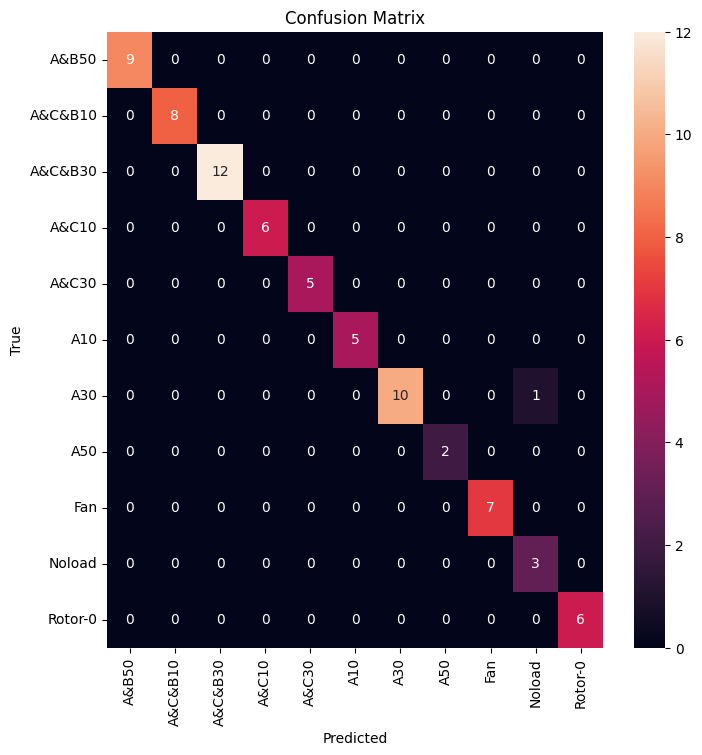

In [30]:
cm = confusion_matrix(classes_test, classes_pred)
plt.figure(figsize = (8, 8))
sns.heatmap(cm, annot = True, fmt = 'd', xticklabels = class_mapping.keys(), yticklabels = class_mapping.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

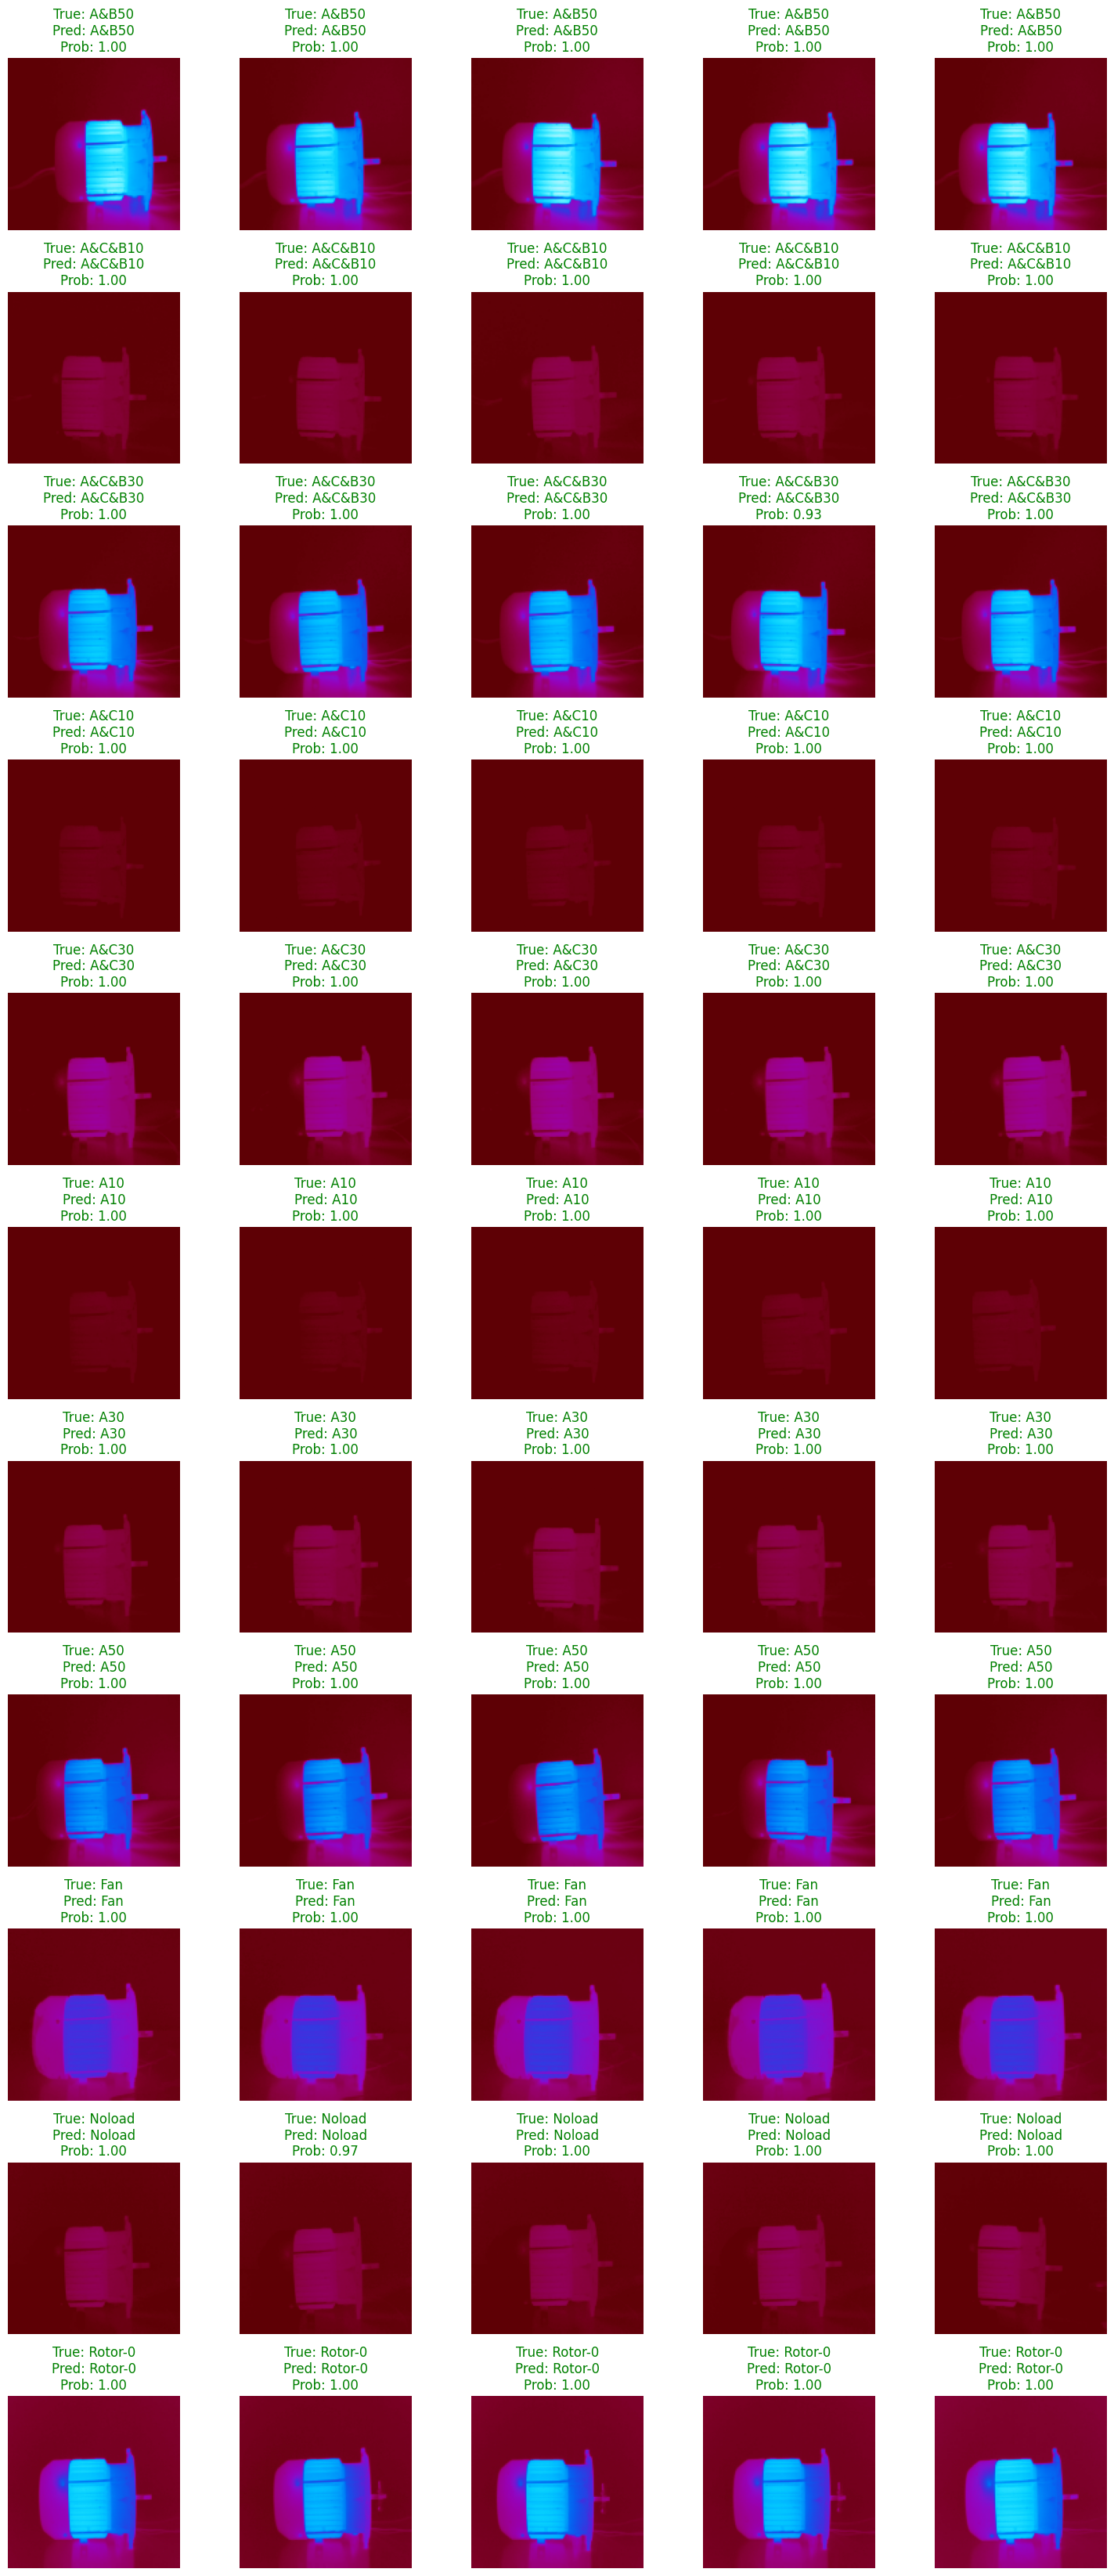

In [31]:
reverse_class_mapping = {v: k for k, v in class_mapping.items()}
num_images = 5

fig, axes = plt.subplots(len(class_mapping), num_images, figsize = (15, len(class_mapping) * 3))


for i, (class_name, class_idx) in enumerate(class_mapping.items()):
    
    class_indices = np.where(labels == class_idx)[0][:num_images]
    
    for j, idx in enumerate(class_indices):
        img = images[idx]
        true_label = reverse_class_mapping[labels[idx]]
    
        img_expanded = np.expand_dims(img, axis = 0)
        prediction = model.predict(img_expanded, verbose = 0)
        predicted_label = reverse_class_mapping[np.argmax(prediction)]
        probability = np.max(prediction)
        
        correct = predicted_label == true_label
        color = 'green' if correct else 'red'
        
        ax = axes[i, j]
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f'True: {true_label}\nPred: {predicted_label}\nProb: {probability:.2f}', color=color)
    
plt.tight_layout()
plt.show()

In [32]:
# Save the model to the Kaggle working directory
model.save('/kaggle/working/my_model.h5')

print("Model saved to /kaggle/working/my_model.h5")


Model saved to /kaggle/working/my_model.h5


In [35]:
!pip install streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 62.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 106.0 MB/s eta 0:00:0000:01


In [36]:
"""import streamlit as st
import numpy as np
import tensorflow as tf
from PIL import Image

# Load the trained model/kaggle/input/thermal-images-of-induction-motor
model = tf.keras.models.load_model('my_model.h5')

# Define the new class labels
class_labels = ['Fan', 'A&C10', 'A&B50', 'A&C30', 'Noload', 'Rotor-0', 'A&C&B30', 'A30', 'A&C&B10', 'A50', 'A10']

# Streamlit app
st.title("thermal-images-of-induction-motor Detection with CNN")
st.write("Upload an image, and the model will predict the type of engine.")

# File uploader
uploaded_file = st.file_uploader("Upload an Image", type=["bmp"])

# If an image is uploaded
if uploaded_file is not None:
    # Display uploaded image
    image = Image.open(uploaded_file)
    st.image(image, caption='Uploaded Image', use_container_width=True)

    # Preprocess the image
    image = image.resize((320, 240))  # Resize to 320x240
    image = np.array(image) / 255.0  # Normalize the image
    image = np.expand_dims(image, axis=0)  # Add batch dimension

    # Make predictions
    predictions = model.predict(image)
    predicted_class = class_labels[np.argmax(predictions)]
    confidence_scores = predictions[0]

    # Display results
    st.write("### Prediction Results")
    st.write(f"Predicted Class: {predicted_class}")

    # Display confidence scores
    st.write("### Confidence Scores")
    for label, score in zip(class_labels, confidence_scores):
        st.write(f"{label}: {score:.2%}")"""


2024-12-23 11:27:01.077 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-23 11:27:01.171 
  command:

    streamlit run /opt/conda/lib/python3.10/site-packages/ipykernel_launcher.py [ARGUMENTS]
2024-12-23 11:27:01.171 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-23 11:27:01.172 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-23 11:27:01.173 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-23 11:27:01.173 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-23 11:27:01.174 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-23 11:27:01.174 Thread 'MainThread': missi